<a href="https://colab.research.google.com/github/tanyasheru23/NYC_Taxi_fare_prediction/blob/main/NYC_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [1]:
from google.colab import files
files.upload()  # Choose the API key JSON file from your computer to upload

Saving kaggle.json to kaggle.json


{'kaggle.json': b'---------------------------'}

In [5]:
# Move the uploaded API key JSON file to the Kaggle directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions for the API key file
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [6]:
!mkdir -p ~/.kaggle
!cp '/content/drive/MyDrive/path_to_your_api_key/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/path_to_your_api_key/kaggle.json': No such file or directory


In [7]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

new-york-city-taxi-fare-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
import zipfile

# Specify the path to the ZIP file you want to unzip
zip_file_path = '/content/new-york-city-taxi-fare-prediction.zip'

# Specify the directory where you want to extract the contents
extract_to_directory = '/content'

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the ZIP file to the specified directory
    zip_ref.extractall(extract_to_directory)

print(f'Unzipped {zip_file_path} to {extract_to_directory}')

Unzipped /content/new-york-city-taxi-fare-prediction.zip to /content


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

In [3]:
df = pd.read_csv('train.csv', nrows=100000)
df_test = pd.read_csv('test.csv')
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
print(df.shape,"\n\n", df.info(),"\n\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB
(100000, 8) 

 None 

          fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  100000.000000     100000.000000    100000.000000      100000.000000   
mean       11.354652        -72.494682        39.914481         -72.490967   
std         9.716777         10.693934         6.225686          10.471386   
min 

In [5]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [6]:
df_test.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.dropna(axis=0, inplace=True)
np.sum(pd.isnull(df))

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [9]:
df[df['fare_amount']<0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,2010-03-09 23:37:10.0000005,-2.9,2010-03-09 23:37:10 UTC,-73.789450,40.643498,-73.788665,40.641952,1
2486,2015-03-22 05:14:27.0000001,-2.5,2015-03-22 05:14:27 UTC,-74.000031,40.720631,-73.999809,40.720539,1
13032,2013-08-30 08:57:10.0000002,-3.0,2013-08-30 08:57:10 UTC,-73.995062,40.740755,-73.995885,40.741357,4
28839,2013-08-11 13:39:10.0000001,-2.5,2013-08-11 13:39:10 UTC,-73.785260,40.648442,0.000000,0.000000,1
36722,2015-04-30 15:19:45.0000003,-2.5,2015-04-30 15:19:45 UTC,-73.952187,40.790112,-73.950043,40.792839,1
42337,2015-03-09 10:29:46.0000004,-5.0,2015-03-09 10:29:46 UTC,-73.990974,40.755985,-73.980820,40.759869,1
56748,2015-06-26 01:13:18.0000002,-5.0,2015-06-26 01:13:18 UTC,-73.979797,40.743240,-73.981216,40.737240,6
58937,2010-02-19 23:47:10.0000002,-44.9,2010-02-19 23:47:10 UTC,-73.871120,40.773902,-73.676533,40.786890,1
97838,2015-06-07 02:54:14.0000004,-3.0,2015-06-07 02:54:14 UTC,-73.913246,40.766212,-73.914963,40.764065,5



As there are few negative and zero values for the fare, let's set the minimum fare amount

In [10]:
# Setting minimum fare amount to zero.
df['fare_amount'][df['fare_amount']<0] = 0.1
df[df['fare_amount']<0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count


### FEATURE EXTRACTION

Using the pickup_datetime feature, various features were also extracted such as time, weekday, month etc. As time plays an important role in the fare prices, as they vary with busy traffic schedules.

In [11]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)

In [12]:
df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.day_name()
df.loc[:, 'pickup_date'] = df['pickup_datetime'].dt.day
df.loc[:, 'pickup_month'] = df['pickup_datetime'].dt.month
df.loc[:, 'pickup_day'] = df['pickup_datetime'].dt.dayofweek


df_test.loc[:, 'pickup_hour'] = df_test['pickup_datetime'].dt.hour
df_test.loc[:, 'pickup_weekday'] = df_test['pickup_datetime'].dt.day_name()
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.day
df_test.loc[:, 'pickup_month'] = df_test['pickup_datetime'].dt.month
df_test.loc[:, 'pickup_day'] = df_test['pickup_datetime'].dt.dayofweek

In [13]:
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_weekday,pickup_date,pickup_month,pickup_day
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,Monday,15,6,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,Tuesday,5,1,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,Thursday,18,8,3
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,Saturday,21,4,5
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,Tuesday,9,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2013-09-24 07:39:00.00000071,9.0,2013-09-24 07:39:00+00:00,-73.947977,40.784792,-73.964262,40.792347,5,7,Tuesday,24,9,1
99996,2014-05-15 12:15:45.0000001,6.0,2014-05-15 12:15:45+00:00,-73.962918,40.799107,-73.974178,40.786487,1,12,Thursday,15,5,3
99997,2015-02-19 17:40:43.0000001,5.0,2015-02-19 17:40:43+00:00,-73.996773,40.723549,-73.991974,40.724724,1,17,Thursday,19,2,3
99998,2009-10-10 23:35:00.000000165,6.9,2009-10-10 23:35:00+00:00,-73.983652,40.756667,-73.982715,40.767067,4,23,Saturday,10,10,5


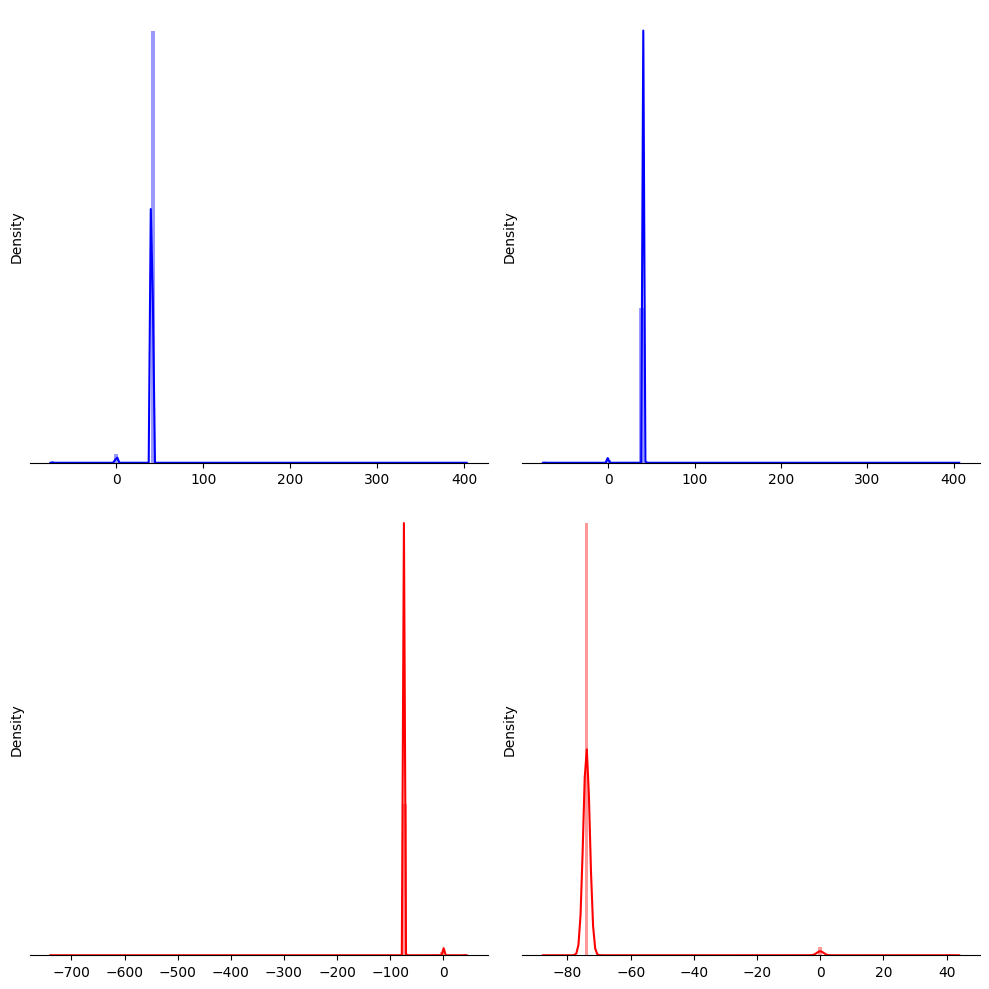

In [14]:
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sb.despine(left=True)
sb.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sb.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sb.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sb.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()


###Findings
 (Here, red represents pickup and dropoff Longitudes & blue represents pickup & dropoff lattitudes)

1. From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73.
2. Some extreme co-ordinates has squeezed the plot such that we see a spike here
3. A good idea is to remove these outliers and look at the distribution more closely

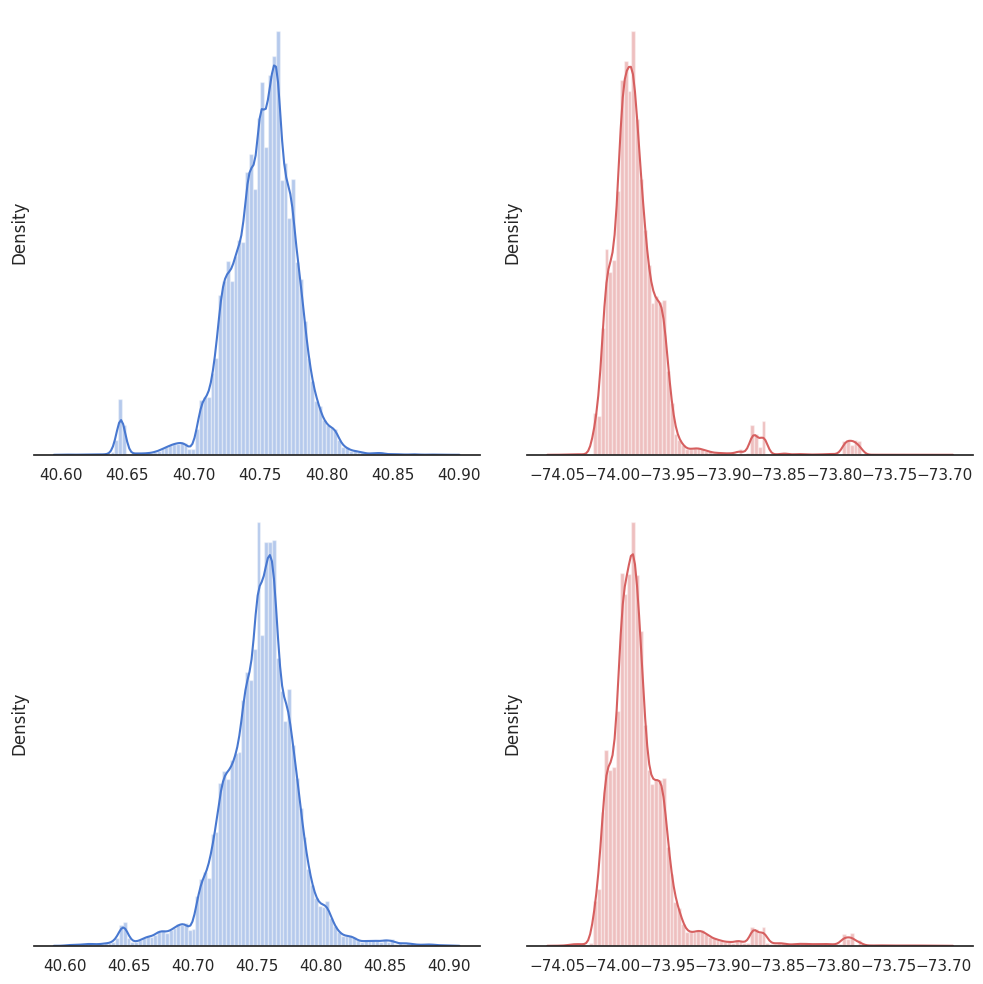

In [15]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sb.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sb.despine(left=True)
sb.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sb.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sb.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sb.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

###Feature extraction

Here various methods of distances were calculated viz. Manhattan, Euclidean and Haversine.

But as the corrlation of these were near about = 0.99 hence, ended up removing the Manhattan and Euclidean distances as they add redundancy to the model.

In [16]:
def haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

df['haversine_distance'] = haversine_distance(df['pickup_latitude'].values,
                                                     df['pickup_longitude'].values,
                                                     df['dropoff_latitude'].values,
                                                     df['dropoff_longitude'].values)
df_test['haversine_distance'] = haversine_distance(df_test['pickup_latitude'].values,
                                                     df_test['pickup_longitude'].values,
                                                     df_test['dropoff_latitude'].values,
                                                     df_test['dropoff_longitude'].values)

In [17]:
df['haversine_distance'].median(), df['haversine_distance'].mean()

(2.152803685790151, 3.280894538507157)

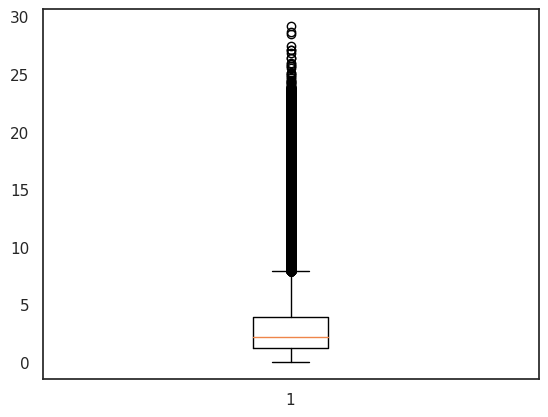

In [18]:
plt.boxplot(df['haversine_distance'])
plt.show()

 As there are few outliers let's remove them using the IQR and see the affect on number of data points.

 If there is no big difference in the number of data points let's remove them and use the new data.

In [19]:
IQR = df['haversine_distance'].quantile(0.75) - df['haversine_distance'].quantile(0.25)
IQR

2.6445632516961988

In [20]:
Q1 = df['haversine_distance'].quantile(0.25)
Q3 = df['haversine_distance'].quantile(0.75)
whisker_1 = Q1 - (1.5*IQR)
whisker_2 = Q3 + (1.5*IQR)

whisker_1, whisker_2

(-2.7114900273961298, 7.866762979388666)

In [21]:
df = df.loc[(df['haversine_distance']!=0) & (df['haversine_distance']<8)]
df.shape

(88627, 14)

Check wether any variable or column is showing multicollinearity with other variables.

In [22]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
# the independent variables set
X =df.drop(['key', 'pickup_datetime','pickup_weekday', 'fare_amount'], axis = 1)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              feature           VIF
0    pickup_longitude  1.801040e+07
1     pickup_latitude  5.262471e+06
2   dropoff_longitude  1.842213e+07
3    dropoff_latitude  4.632861e+06
4     passenger_count  2.660648e+00
5         pickup_hour  5.450120e+00
6         pickup_date  4.255785e+00
7        pickup_month  4.281144e+00
8          pickup_day  3.487932e+00
9  haversine_distance  3.241042e+00


As we can see that pickup_longitude, pickup_latitude, dropoff_longitude and dropoff_latitude have values of (~10^6) i.e. >5

We can drop any of the 2 of 4 atrributes which have high correlation

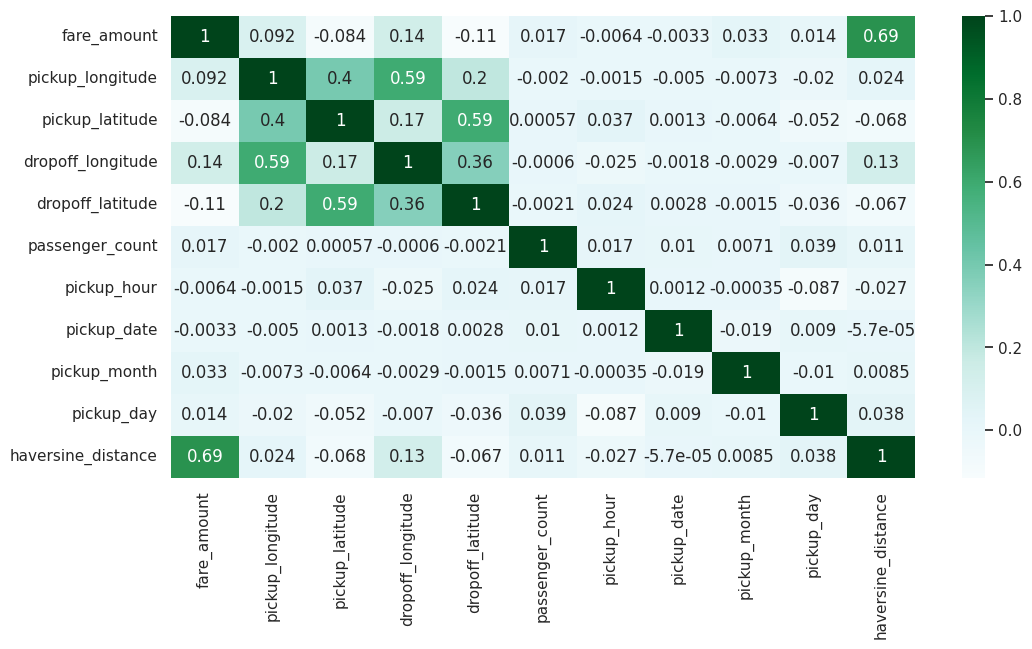

In [23]:
plt.figure(figsize = (12,6))
sb.heatmap(df.drop(['key', 'pickup_datetime','pickup_weekday'], axis = 1).corr(),
           cmap ='BuGn', annot = True);

In [24]:
df[['pickup_latitude', 'pickup_longitude', 'dropoff_longitude', 'dropoff_latitude']].corr()

,pickup_latitude,pickup_longitude,dropoff_longitude,dropoff_latitude
pickup_latitude,1.000000,0.395051,0.166610,0.591759
pickup_longitude,0.395051,1.000000,0.593426,0.195972
dropoff_longitude,0.166610,0.593426,1.000000,0.357076
dropoff_latitude,0.591759,0.195972,0.357076,1.000000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88627 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   key                 88627 non-null  object             
 1   fare_amount         88627 non-null  float64            
 2   pickup_datetime     88627 non-null  datetime64[ns, UTC]
 3   pickup_longitude    88627 non-null  float64            
 4   pickup_latitude     88627 non-null  float64            
 5   dropoff_longitude   88627 non-null  float64            
 6   dropoff_latitude    88627 non-null  float64            
 7   passenger_count     88627 non-null  int64              
 8   pickup_hour         88627 non-null  int64              
 9   pickup_weekday      88627 non-null  object             
 10  pickup_date         88627 non-null  int64              
 11  pickup_month        88627 non-null  int64              
 12  pickup_day          88627 non-nu

We need to remove few columns that are irrelevant for our model or are transformed into useful attributes

In [26]:
X=df.drop(["key","pickup_datetime","pickup_weekday","fare_amount"],axis=1)
y=df["fare_amount"]
X.shape, y.shape

((88627, 10), (88627,))

Standardizing the data into zero mean and unit variance

In [27]:
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 6.21493248, -1.31680653,  5.95968832, -1.56478694, -0.51688021,
         0.53225828, -0.07600096, -0.07398561, -1.56325012, -0.86218178],
       [-0.13179443,  0.38672213, -0.56637125, -0.06778567,  0.25266593,
        -2.09734508,  0.26953958,  0.50488199, -0.02024791, -0.64952736],
       [-0.33316283, -0.81262584, -0.58054582,  0.22665639, -0.51688021,
        -1.47861488,  0.61508012, -0.65285321,  1.00842023,  0.18609377],
       [ 0.53957115,  0.67403349,  0.94210837,  1.23041834, -0.51688021,
        -1.01456722, -0.76708203, -0.94228701, -1.04891605, -0.28817051],
       [-0.96743664, -0.87714084,  0.23394682,  0.23216984, -0.51688021,
        -0.70520212, -1.11262257, -1.5211546 , -0.02024791,  0.77170864]])

### Train-Test split

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
print(X_train.ndim)
print(y_train.ndim)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

2
1
(62038, 10)
(62038,)
(26589, 10)
(26589,)


##LINEAR REGRESSION MODEL

In [29]:
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Root Mean Square Error (RMSE) using Linear Regression on training data:", rmse_train)
print("Root Mean Square Error (RMSE) using Linear Regression on validation data:", rmse_val)

Root Mean Square Error (RMSE) using Linear Regression on training data: 3.7303103819307277
Root Mean Square Error (RMSE) using Linear Regression on validation data: 3.5771865581892563


In [30]:
from sklearn.model_selection import cross_val_score

np.mean(cross_val_score(model, X_train, y_train, cv=5))

0.4928455080201104

### POLYNOMIAL REGRESSION MODEL
Using different valus of degree

In [31]:
from sklearn.preprocessing import PolynomialFeatures

rmse_list=[]
for p in range(2,5):
  poly_features = PolynomialFeatures(p)
  x_train_poly = poly_features.fit_transform(X_train)
  x_valid_poly = poly_features.fit_transform(X_val)
  regr = LinearRegression().fit(x_train_poly,y_train)

  y_pred_train = regr.predict(x_train_poly)
  y_pred_val = regr.predict(x_valid_poly)

  rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
  rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
  print(f"\n The RMSE value of predicted and original Fare-Amount with polynomial degree = {p} on training data is {rmse_train}")
  print(f"\n The RMSE value of predicted and original Fare-Amount with polynomial degree = {p} on validation data is {rmse_val}")


 The RMSE value of predicted and original Fare-Amount with polynomial degree = 2 on training data is 3.596202730959942

 The RMSE value of predicted and original Fare-Amount with polynomial degree = 2 on validation data is 3.463775074933503

 The RMSE value of predicted and original Fare-Amount with polynomial degree = 3 on training data is 3.503772001068168

 The RMSE value of predicted and original Fare-Amount with polynomial degree = 3 on validation data is 3.4271100067071143

 The RMSE value of predicted and original Fare-Amount with polynomial degree = 4 on training data is 3.3531475076015913

 The RMSE value of predicted and original Fare-Amount with polynomial degree = 4 on validation data is 3.6136749070069354


### RIDGE REGRESSION MODEL

In [32]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_valid_poly = poly.transform(X_val)

alpha = 0.001
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train_poly, y_train)

y_pred_train = ridge_model.predict(X_train_poly)
y_pred_val = ridge_model.predict(X_valid_poly)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Root Mean Square Error (RMSE) using Ridge Regression on training data:", rmse_train)
print("Root Mean Square Error (RMSE) using Ridge Regression on validation data:", rmse_val)

Root Mean Square Error (RMSE) using Ridge Regression on training data: 3.597367153990055
Root Mean Square Error (RMSE) using Ridge Regression on validation data: 3.466218005637418


In [33]:
np.mean(cross_val_score(ridge_model, X_train, y_train, cv=5))

0.49284550804816796

### LASSO REGRESSION MODEL

In [35]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_valid_poly = poly.transform(X_val)

alpha = 0.001
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train_poly, y_train)

y_pred_train = lasso_model.predict(X_train_poly)
y_pred_val = lasso_model.predict(X_valid_poly)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Root Mean Square Error (RMSE) using Lasso Regression on training data:", rmse_train)
print("Root Mean Square Error (RMSE) using Lasso Regression on validation data:", rmse_val)

Root Mean Square Error (RMSE) using Lasso Regression on training data: 3.601678685995427
Root Mean Square Error (RMSE) using Lasso Regression on validation data: 3.472063495261603


In [36]:
np.mean(cross_val_score(lasso_model, X_train, y_train, cv=5))

0.4928472246630653

### CONCLUSION

After testing with various regression models, the RMSE error on validation data is lowest for Lasso Model.

We can say that lasso model is best fit for the used dataset and number of data points.

Model can further be improvised by adding more features or using various kinds of regression model available.

As for this model we have tried best our knowledge